In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from numpy.fft import rfft, rfftfreq
from numpy.fft import fft, fftshift
from scipy.signal import blackman
from scipy.fftpack import fft, fftfreq
# set seeds for reproducibility
seed = 515
np.random.seed(seed)
import os, warnings
import copy
warnings.filterwarnings('ignore')
import IPython
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

__Overview:__

<br>

- Fourier transform provides the frequency domain representation of the original signal.
For example, given a sinusoidal signal which is in time domain the Fourier Transform provides the constituent signal frequencies.
- Using Fourier transform both periodic and non-periodic signals can be transformed from time domain to frequency domain.

<br>

__Example:__

The Python example creates two sine waves and they are added together to create one signal. When the Fourier transform is applied to the resultant signal it provides the frequency components present in the sine wave.

In [2]:
def create_sin_wave(freq, time):
    return np.sin(2 * np.pi * freq * time)


def create_cosine_wave(freq, time):
    return np.cos(2 * np.pi * freq * time)


def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)


### Demonstration

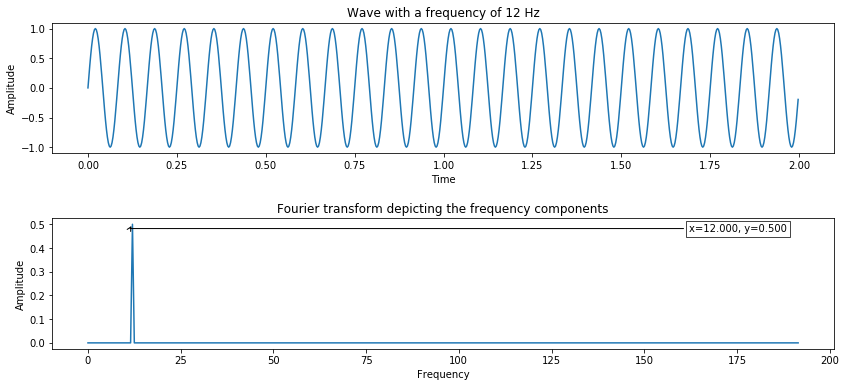

In [3]:
start_tm, end_tm = 0, 2
signal1 = 12  # frequency of the wave
smpl_freq = 32 * signal1  # sampling frequency with oversampling factor=32
smpl_intv = 1 / smpl_freq  # intervals time points are sampled
tm = np.arange(start_tm, end_tm, smpl_intv)
ampl1 = np.sin(2 * np.pi * signal1 * tm)  # generate sine wave
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
plt.subplots_adjust(hspace=.5)
axes[0].set_title(f'Wave with a frequency of {signal1} Hz')
axes[0].plot(tm, ampl1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
ft_ = np.fft.fft(ampl1) / len(ampl1)  # Normalize amplitude and apply the FFT
ft_ = ft_[range(int(len(ampl1)/2))]   # Exclude sampling frequency
tp_cnt = len(ampl1)
val_ = np.arange(int(tp_cnt / 2))
tm_period_ = tp_cnt / smpl_freq
freq_ = val_ / tm_period_
axes[1].set_title('Fourier transform depicting the frequency components')
axes[1].plot(freq_, abs(ft_))
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Amplitude')
annot_max(freq_, abs(ft_), ax=axes[1])
plt.show()

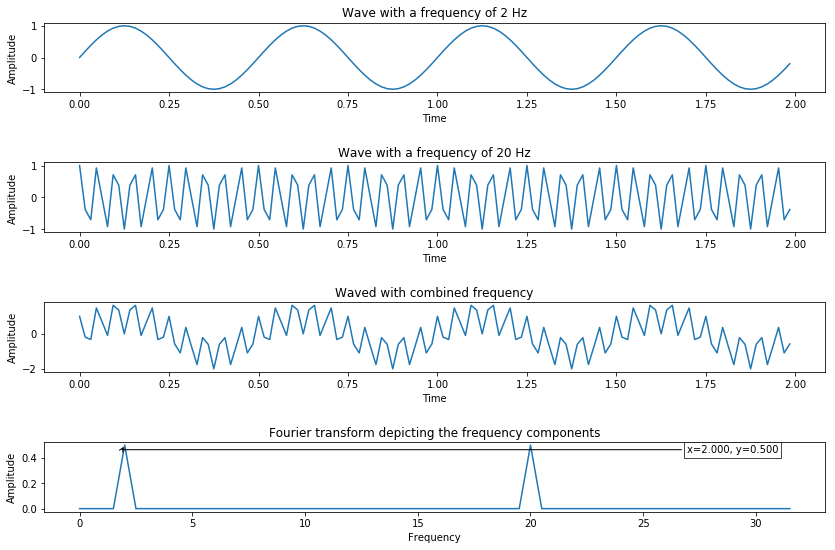

In [4]:
start_tm, end_tm = 0, 2
# Frequency of the signals
signal1Frequency = 2
signal2Frequency = 20
smpl_freq = 32*signal1Frequency
smpl_intv = 1 / smpl_freq  # intervals time points are sampled
tm = np.arange(start_tm, end_tm, smpl_intv)
# Create two sine waves
ampl1 = create_sin_wave(signal1Frequency, tm)
ampl2 = create_cosine_wave(signal2Frequency, tm)
combined_ampl = ampl1 + ampl2

fig, axes = plt.subplots(4, 1, figsize=(14, 9))
plt.subplots_adjust(hspace=1)
axes[0].set_title(f'Wave with a frequency of {signal1Frequency} Hz')
axes[0].plot(tm, ampl1)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[1].set_title(f'Wave with a frequency of {signal2Frequency} Hz')
axes[1].plot(tm, ampl2)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[2].set_title('Waved with combined frequency')
axes[2].plot(tm, combined_ampl)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Amplitude')

ft_ = np.fft.fft(combined_ampl) / len(combined_ampl)  # Normalize amplitude
ft_ = ft_[range(int(len(combined_ampl)/2))]  # Exclude sampling frequency
tp_cnt = len(combined_ampl)
val_ = np.arange(int(tp_cnt / 2))
tm_period_ = tp_cnt / smpl_freq
freq_ = val_ / tm_period_

# Frequency domain representation
axes[3].set_title('Fourier transform depicting the frequency components')
axes[3].plot(freq_, abs(ft_))
axes[3].set_xlabel('Frequency')
axes[3].set_ylabel('Amplitude')
annot_max(freq_, abs(ft_), ax=axes[3])
plt.show()


### Use case with real data

To detect if there is a cycle pattern of CO2 Emissions.

In [5]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors='coerce')
df = pd.read_csv("../Data/datasets_324_699_MER_T12_06.csv", 
                 parse_dates=['YYYYMM'], 
                 index_col='YYYYMM', 
                 date_parser=dateparse) 
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.dropna(inplace=True)
ts.drop(['Unit', 'MSN', 'Column_Order'], axis=1, inplace=True)

Quickly plot the timeseries

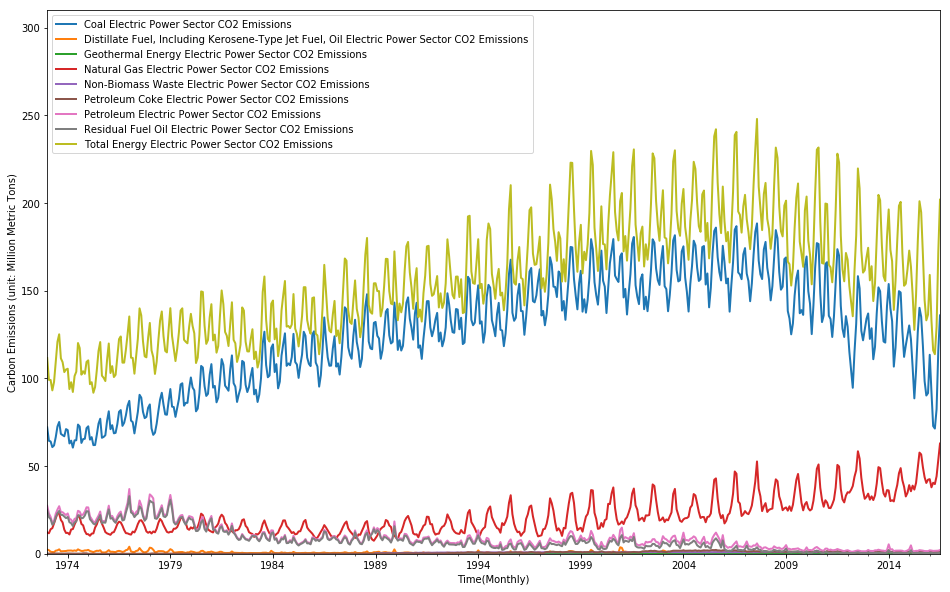

In [6]:
fig, ax = plt.subplots(figsize=(16, 10))
_tmp_df = ts.reset_index()
for key, grp in _tmp_df.groupby('Description'):
    ax = grp.plot(ax=ax, kind='line', x='YYYYMM', y='Value', label=key, lw=2)
    
ax.legend(loc='upper left')
ax.set_xlabel('Time(Monthly)')
_ = plt.ylim(0, _tmp_df['Value'].max() * 1.25)
_ = plt.ylabel('Carbon Emissions (unit: Million Metric Tons)')
_ = plt.show()

Now we can plot each CO2 Emission individually (because the value is quite different)

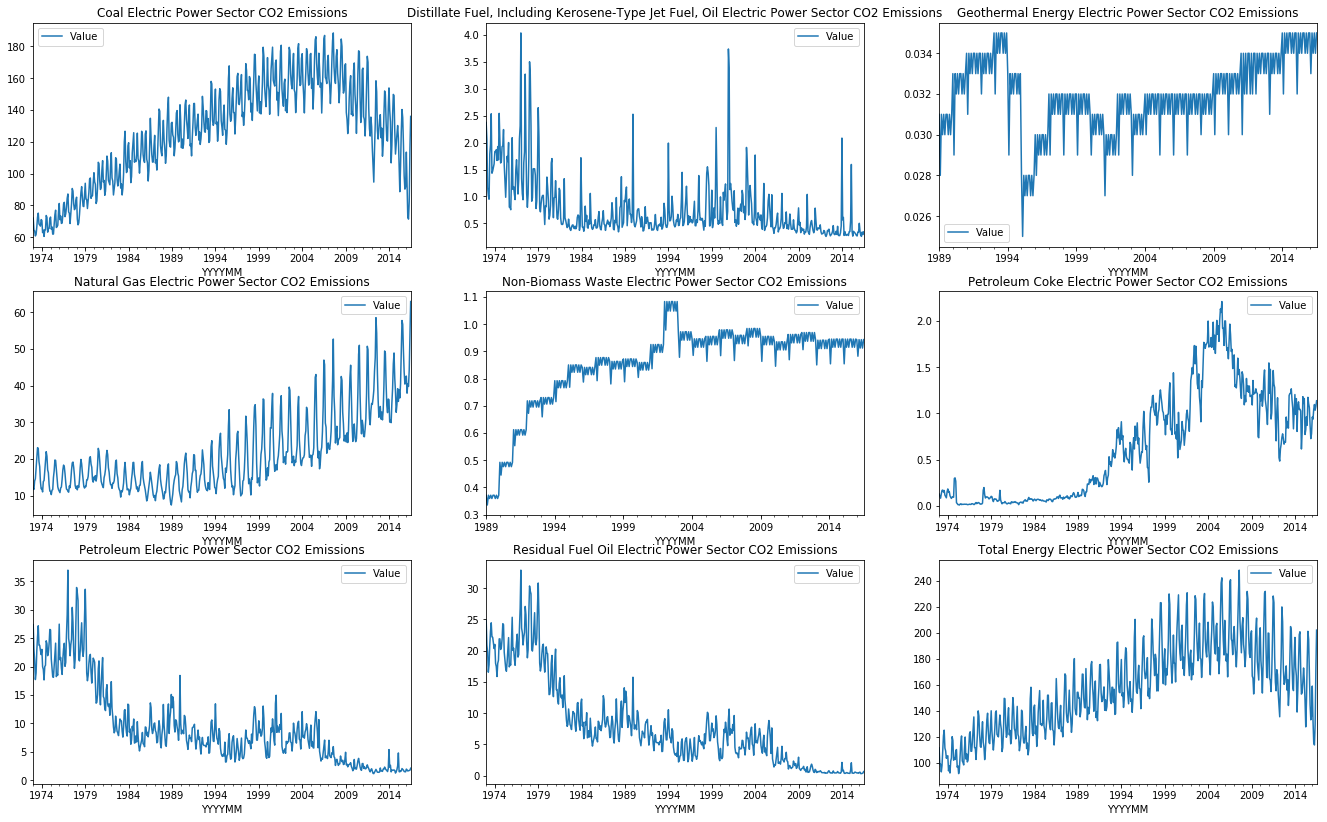

In [7]:
fig, axes = plt.subplots(3,3, figsize = (23, 14))
for (desc, group), ax in zip(_tmp_df.groupby('Description'), axes.flatten()):
    group.plot(x='YYYYMM', y='Value', title=desc, ax=ax)
    
plt.show()

Select one type of emission... in this example, select `Natural Gas Electric Power Sector CO2 Emissions`

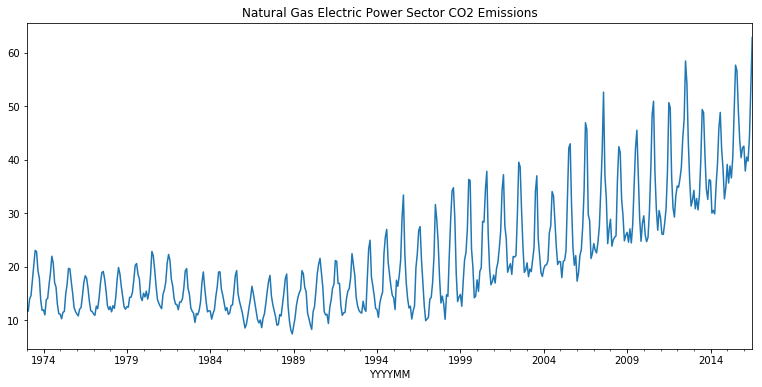

,Value,Description
YYYYMM,,
1973-01-01,12.175,Natural Gas Electric Power Sector CO2 Emissions
1973-02-01,11.708,Natural Gas Electric Power Sector CO2 Emissions
1973-03-01,13.994,Natural Gas Electric Power Sector CO2 Emissions


In [8]:
def get_indiv_emission(df, sel_desc: str, 
                       plot_mode: bool=True):
    _df = df.loc[df['Description'] == sel_desc]
    if plot_mode:
        _df.plot(x='YYYYMM', y='Value', figsize=(13, 6), legend=False, title=sel_desc)
        plt.show()
    
    _df = _df.set_index('YYYYMM')
    display(_df.head(3))
    return _df


sel_df = get_indiv_emission(_tmp_df, 'Natural Gas Electric Power Sector CO2 Emissions')

Build FFT - Blackman window is being used and substract the median before multiplying by the window function. The median() provides the estimate of baseline better than the mean().


Again, the choice of window function can be experiment using various method (i.e. tukey, hamming)

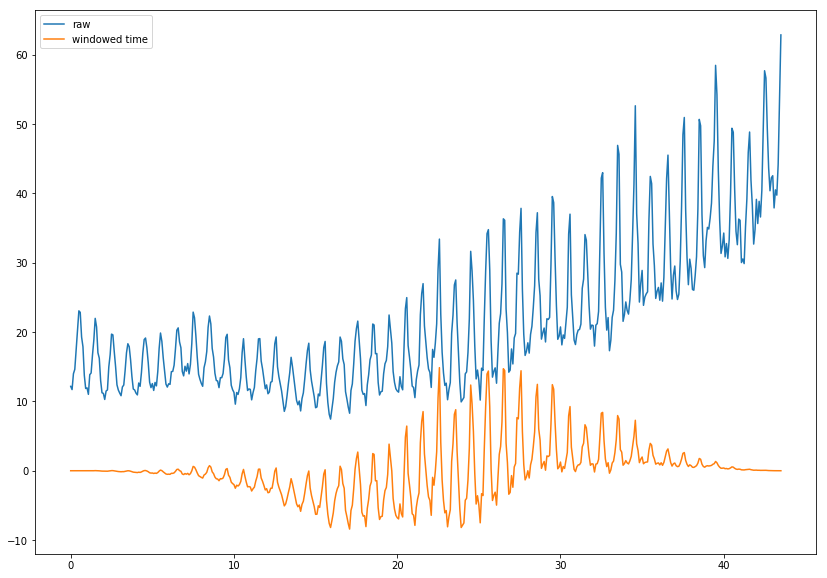

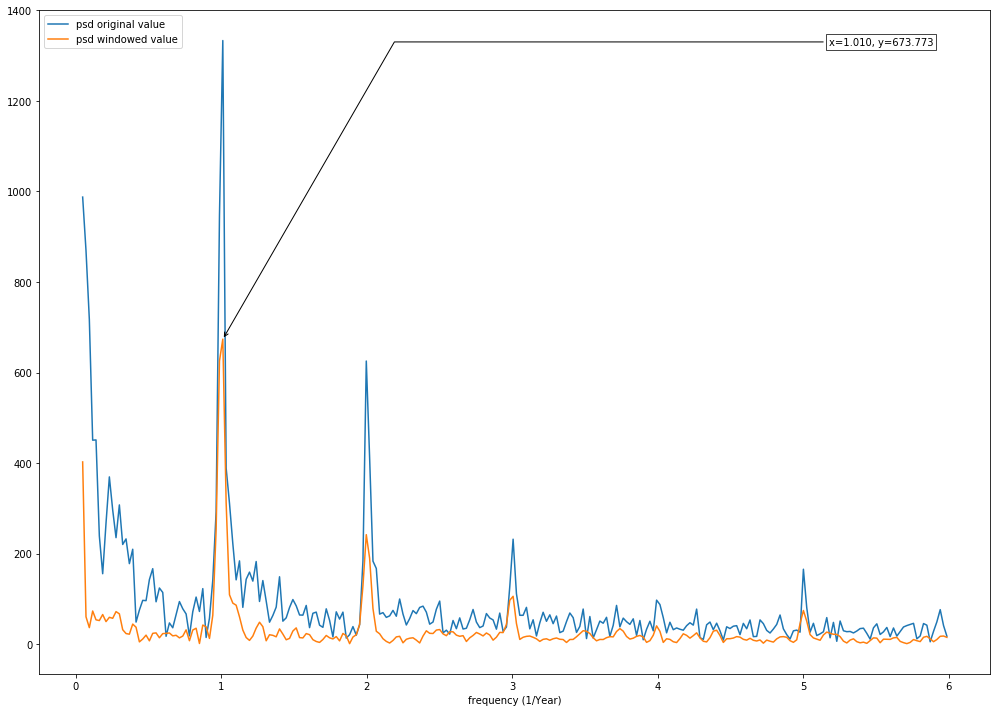

In [9]:
from scipy.signal import blackman

def plot_ori_window(time_: np.ndarray, 
                    val_orig: pd.core.series.Series, 
                    val_window: pd.core.series.Series):
    plt.figure(figsize=(14, 10))
    plt.plot(time_, val_orig, label='raw')
    plt.plot(time_, val_window, label='windowed time')
    plt.legend()
    plt.show()
    return


def plot_ft_result(val_orig_psd: np.ndarray, 
                   val_widw_psd: np.ndarray,
                   ft_smpl_freq: np.ndarray,
                   pos: int=2, annot_mode: bool=True
                  ):
    """
    For PSD graph, the first few points are removed because it represents the baseline (or mean)
    """
    plt.figure(figsize=(14, 10))
    plt.plot(ft_smpl_freq[pos: ], val_orig_psd[pos: ], label='psd original value')
    plt.plot(ft_smpl_freq[pos: ], val_widw_psd[pos: ], label='psd windowed value')
    if annot_mode:
        annot_max(ft_smpl_freq[pos:], abs(val_widw_psd[pos: ]))
        
    plt.xlabel('frequency (1/Year)')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    return


_val_orig = sel_df['Value']
_time = np.linspace(0, len(_val_orig) / 12, len(_val_orig), endpoint=False)
_val_widw = (_val_orig - np.median(_val_orig)) * blackman(len(_val_orig))

# rfft() method is used because the data is real valued
# rfftfreq() method is used to generate the frequency list (usage with rfft)
#  remark: the array f contains the frequency bin centers in cycles per unit of the sample spacing
#    with zero at the start. If the sample spacing is in years, then the frequency unit is cycles/year.
_val_orig_psd = abs(rfft(_val_orig))
_val_widw_psd = abs(rfft(_val_widw))
_val_freqs = rfftfreq(len(_val_orig), d=1./12.)

plot_ori_window(time_=_time, val_orig=_val_orig, val_window=_val_widw)
plot_ft_result(val_orig_psd=_val_orig_psd, val_widw_psd=_val_widw_psd, ft_smpl_freq=_val_freqs)

In [10]:
tmp = pd.DataFrame({'freq':_val_freqs[2: ], 'y':_val_widw_psd[2: ]})
tmp['year'] = 1/tmp['freq']
tmp['months'] = tmp['year'] * 12
tmp.head(3)

,freq,y,year,months
0,0.045889,402.474399,21.791667,261.500000
1,0.068834,60.339007,14.527778,174.333333
2,0.091778,36.414803,10.895833,130.750000


In [11]:
tmp.loc[tmp.y == max(tmp['y'])]

,freq,y,year,months
42,1.00956,673.773327,0.99053,11.886364


Now let's recheck using the seasonal_decompose() method from `statsmodels`

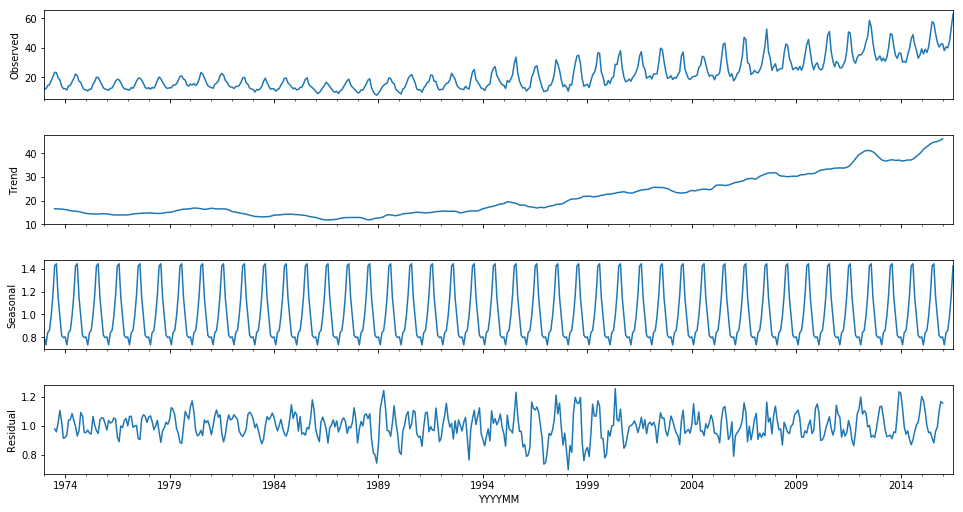

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(_val_orig, model='multiplicative', freq=12)
fig = result.plot()
fig.set_size_inches(15, 8)
plt.show()

The result from FFT and seasonal_decompose is aligned with seasonality happened every (approx. 1 year)